# Data augmentation with paraphraser

There are a number of methods for augmenting our textual data. One of the approaches we propose here is to use paraphrase models to augment our data by increasing the number of contexts.

## Prerequise packages

In [1]:
from sentence_transformers import SentenceTransformer, util
import language_tool_python
import glob
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, HTML
import tools

/home/mohamed/miniconda3/envs/mdner/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Paraphrase evaluation

We will try different types of paraphrasers in order to determine the best one. We will compare 5 models, namely mBART, Pegasus, Bart-paraphrase, Parrot. These models were chosen arbitrarily. To evaluate the performance of the different models, we will use the following metrics:

* Entity conservation: The number of conserved entities makes it possible to ensure that certain entities are conserved, in particular molecule entities.

* Length text: Allows you to determine if the size of the texts has changed 

* Sentence similarity: Sentence similarity describes how semantically similar two sentences are. By vectorizing the sentences, we will determine the cosine similarity and see how closely they are related.

* Checking Grammar: We will check for gammatical errors.

### Entity conservation

We propose that preserving entities is crucial for achieving high performance in Named Entity Recognition (NER). To test this hypothesis, we calculate the occurrence of preserved entities in paraphrases using a case-insensitive string matching approach.

In [2]:
path = "../annotations_paraphrase/"
names_model = ["bart", "pegasus", "mBART"]
dfs = []
nents = {name_model: [[], []] for name_model in names_model}
for name_model in names_model :
    matchs = {"MOL": 0, "TEMP": 0, "STIME": 0, "FFM": 0, "SOFT": 0}
    totals = {"MOL": 0, "TEMP": 0, "STIME": 0, "FFM": 0, "SOFT": 0}
    for path_json in glob.glob(path + "*.json"):
        content = tools.get_content(path_json, names_model + ["er"], name_model)
        if content != None :
            r_txt, p_txt, r_annotations, p_annotations = content
            r_ents = [(r_txt[ent[0] : ent[1]].lower(), ent[2]) for ent in r_annotations["entities"]]
            p_ents = [(p_txt[ent[0] : ent[1]].lower(), ent[2]) for ent in p_annotations["entities"]]
            nents[name_model][0].append(len(r_ents))
            nents[name_model][1].append(len(p_ents))
            for ent in r_ents:
                if ent in p_ents:
                    matchs[ent[1]] += 1
                    p_ents.remove(ent)
                totals[ent[1]] += 1
    perc = {key: matchs[key] / totals[key] * 100 for key in matchs}
    df = pd.DataFrame.from_dict(
    {"Percentage": perc,
     "Paraphrase": matchs,
     "Reference": totals}
    )
    dfs.append(df)
    
for (name_model, df) in zip(names_model, dfs):
    caption_text = "<b>" + name_model + "</b>"
    df = df.style.set_caption(caption_text)
    display(HTML(df.to_html()))

,Percentage,Paraphrase,Reference
MOL,36.077058,1236,3426
TEMP,33.587786,44,131
STIME,33.862434,64,189
FFM,40.677966,168,413
SOFT,37.669377,139,369


,Percentage,Paraphrase,Reference
MOL,13.952131,478,3426
TEMP,3.053435,4,131
STIME,3.174603,6,189
FFM,10.169492,42,413
SOFT,6.504065,24,369


,Percentage,Paraphrase,Reference
MOL,47.489784,1627,3426
TEMP,64.122137,84,131
STIME,66.137566,125,189
FFM,60.532688,250,413
SOFT,68.292683,252,369


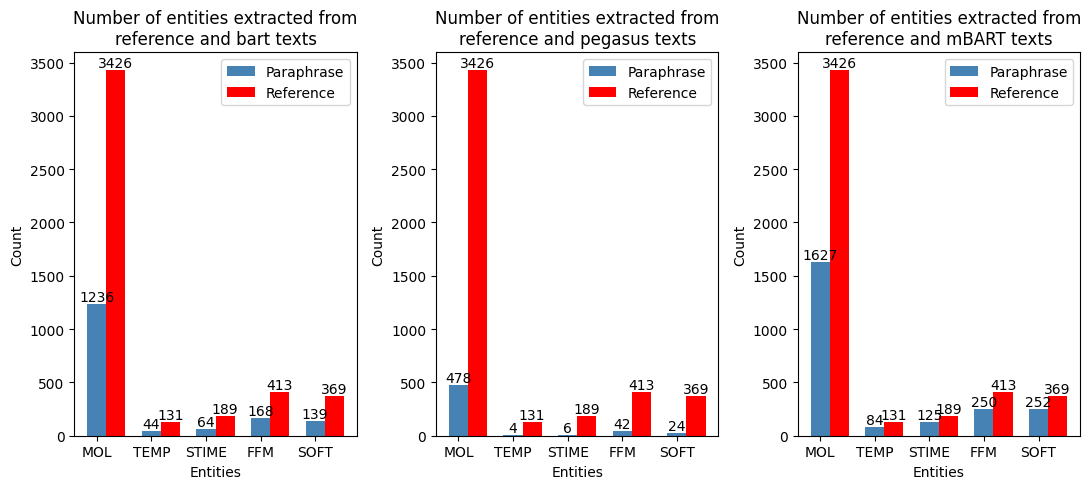

In [5]:
names_model = ["bart", "pegasus", "mBART"]
fig, axes = plt.subplots(1, len(names_model), figsize=(11, 5))

# Get dataframes and axes
for i, (df, ax) in enumerate(zip(dfs, axes)):
    bar_width = 0.35
    bar_positions = range(len(df.index))
    extracted_bars = ax.bar(df.index, list(df["Paraphrase"]), width=bar_width, color='steelblue', label='Paraphrase')
    total_bars = ax.bar([p + bar_width for p in bar_positions], list(df["Reference"]), width=bar_width, color='red', label='Reference')

    for extracted_bar, total_bar in zip(extracted_bars, total_bars):
        ax.text(extracted_bar.get_x() + extracted_bar.get_width() / 2, extracted_bar.get_height(),
                extracted_bar.get_height(), ha='center', va='bottom')
        ax.text(total_bar.get_x() + total_bar.get_width() / 2, total_bar.get_height(),
                total_bar.get_height(), ha='center', va='bottom')

    # Legend and title
    ax.set_xlabel('Entities')
    ax.set_ylabel('Count')
    ax.set_title(f"Number of entities extracted from\nreference and {names_model[i]} texts")
    ax.legend()

plt.tight_layout()
plt.show()

From the results above, we can see that conservation of entities is better with the mBART and Bart-paraphraser models, in contrast to the Pegasus model. Indeed, 13% of the MOL entities obtained with the Pegasus model are preserved, while 39% (+-3% difference respectively) are preserved with the mBART and Bart-paraphraser models. The loss of entities can be explained by the fact that the paraphrase models will summarise the context and so eliminate the presence of repetitive molecules, for example. 

Thus, according to this metric, the Bart and mBART models preserve entities better.

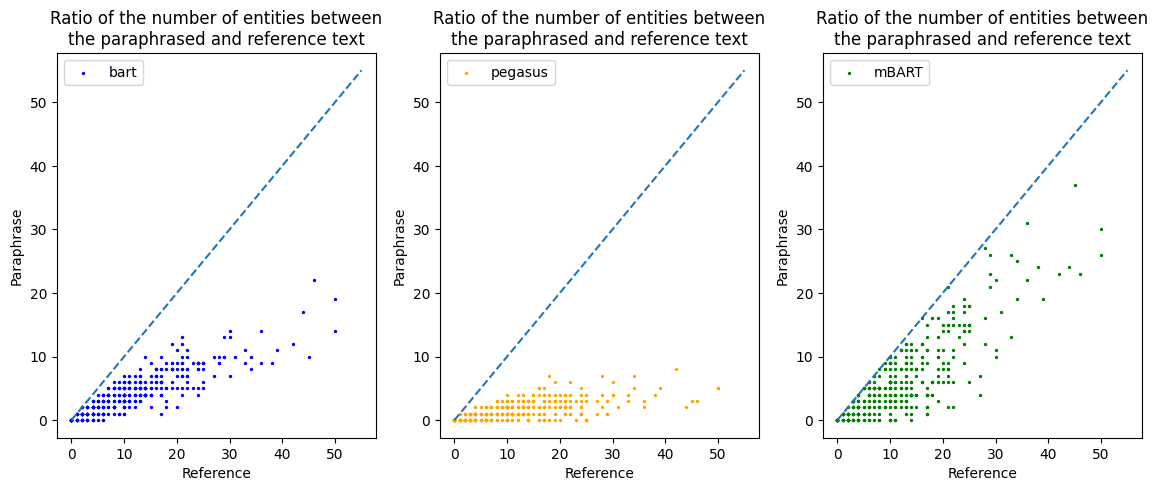

In [6]:
names_model = ["bart", "pegasus", "mBART"]
color = ["blue", "orange", "green"]
fig, axes = plt.subplots(1, len(names_model), figsize=(14, 5))

for i, (name_model, ax) in enumerate(zip(names_model, axes)): 
    ax.scatter(nents[name_model][0], nents[name_model][1], color=color[i], label=name_model, s=2)
    max_lim = max(max(nents[name_model][0]), max(nents[name_model][1])) + 5
    ax.plot([0, max_lim], [0, max_lim], linestyle="dashed")
    ax.legend()
    ax.set_xlabel('Reference')
    ax.set_ylabel('Paraphrase')
    ax.set_title('Ratio of the number of entities between\nthe paraphrased and reference text')
    
plt.show()

The figures illustrate the loss of entities according to the paraphrase models. Each point represents the ratio between the number of entities identified by hand and the number extracted after paraphrasing. The loss is illustrated here by the position of the point clouds in the right-hand frame. There is less loss in the mBart and Bart models but more loss in the Pegasus model. 

### Length text

The length of the texts can be used to check whether the texts generated by a model are not too short and whether they have been changed.

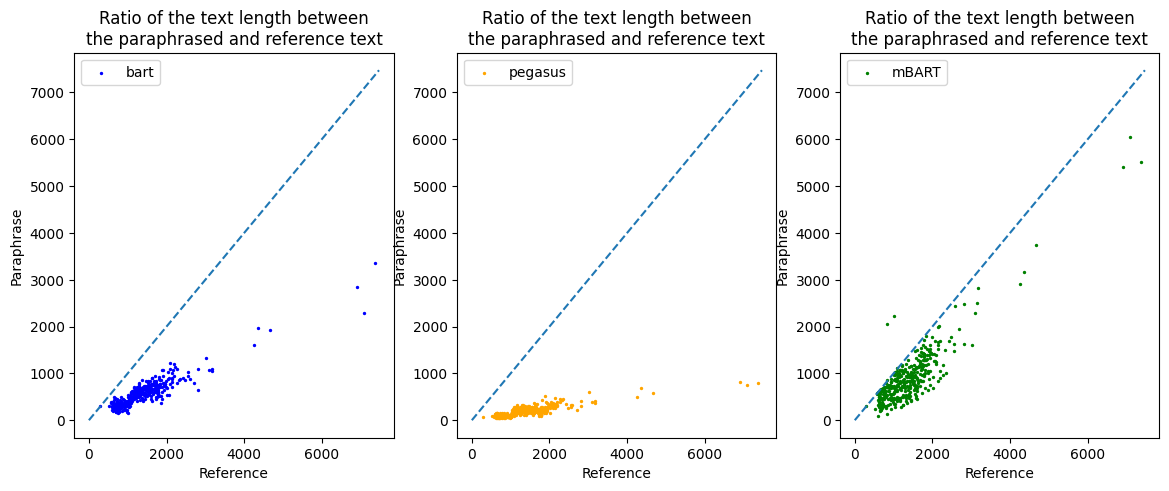

In [7]:
path = "../annotations_paraphrase/"
names_model = ["bart", "pegasus", "mBART"]
len_txts = {name_model: [[], []] for name_model in names_model}

color = ["blue", "orange", "green"]
fig, axes = plt.subplots(1, len(names_model), figsize=(14, 5))

for i, (name_model, ax) in enumerate(zip(names_model, axes)) :
    for path_json in glob.glob(path + "*.json"):
        content = tools.get_content(path_json, names_model + ["er"], name_model)
        if content != None :
            r_txt, p_txt, r_annotations, p_annotations = content
            len_txts[name_model][0].append(len(r_txt))
            len_txts[name_model][1].append(len(p_txt))
    
    ax.scatter(len_txts[name_model][0], len_txts[name_model][1], color=color[i], label=name_model, s=2)
    max_lim = max(max(len_txts[name_model][0]), max(len_txts[name_model][1])) + 100
    ax.plot([0, max_lim], [0, max_lim], linestyle="dashed")
    ax.legend()
    ax.set_xlabel('Reference')
    ax.set_ylabel('Paraphrase')
    ax.set_title('Ratio of the text length between\nthe paraphrased and reference text')        

# Display the plot
plt.show()

The figures above show that the texts generated are shorter than their references. This is quite normal because the paraphrase model reduces the information while retaining the pertinent information. Note that some models accept a maximum number of characters. For example, Bart accepts a maximum text length of 1024 characters. To solve this problem, we have divided the texts according to a defined size, i.e. 1024 characters, and applied a model to each part, which we have concatenated at the end.

The important thing here is that the generated texts are not too short to retain some of the pertinent information. The closer the points are to the line, the more the lengths are equal to the reference texts. Here, the mBart and Bart models generate longer texts than the Pegasus model.

### Sentence similarity

The sentence similarity is used to check that the context is preserved according to the reference text. A sentence similarity close to 0 corresponds to a different context and a sentence similarity close to 1 corresponds to a close context.

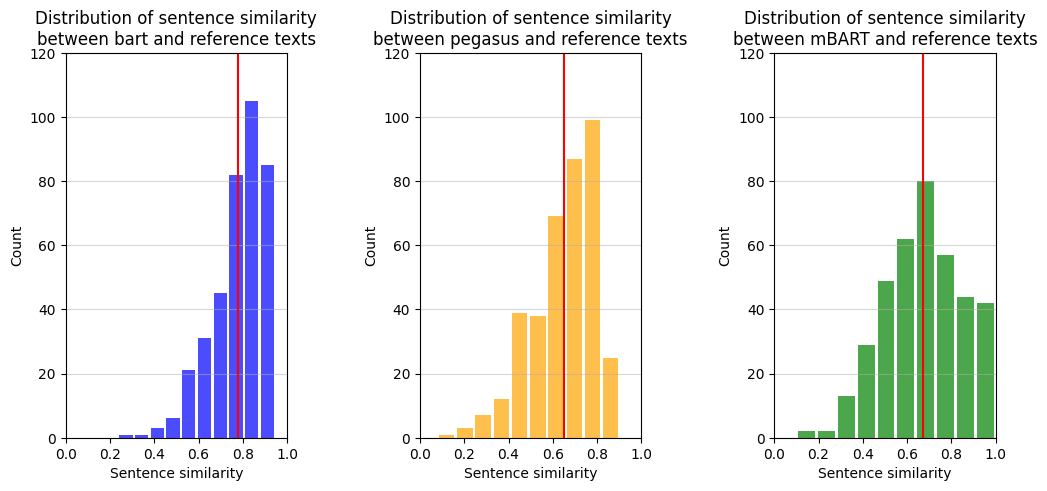

In [8]:
from numpy import median

path = "../annotations_paraphrase/"
sen_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")
names_model = ["bart", "pegasus", "mBART"]
color = ["blue", "orange", "green"]
sen_sim = {name_model: [] for name_model in names_model}

fig, axes = plt.subplots(1, len(names_model), figsize=(12, 5))
plt.subplots_adjust(wspace=0.6)

for i, (name_model, ax) in enumerate(zip(names_model, axes)):
    for path_json in glob.glob(path + "*.json"):
        content = tools.get_content(path_json, names_model + ["er"], name_model)
        if content != None :
            r_txt, p_txt, _, _ = content
            r_txt_encoded = sen_model.encode(r_txt, convert_to_tensor=True)
            p_txt_encoded = sen_model.encode(p_txt, convert_to_tensor=True)
            sen_sim[name_model].append(
                util.pytorch_cos_sim(r_txt_encoded, p_txt_encoded).item()
            )
    ax.hist(sen_sim[name_model], alpha=0.7, rwidth=0.85, color=color[i], label=name_model)
    ax.axvline(x=sum(sen_sim[name_model])/len(sen_sim[name_model]), color = "red", label = "axvline - full height")
    ax.grid(axis='y', alpha=0.5)
    ax.set_xlabel('Sentence similarity')
    ax.set_ylabel('Count')
    ax.set_xlim(0, 1.0)
    ax.set_ylim(0, 120)
    ax.set_title("Distribution of sentence similarity\nbetween " + name_model + " and reference texts")

The figures show that the Bart model is better at preserving context than the other models. In fact, 50% of the texts generated by Bart have a sentence similarity greater than 0.8, whereas for the pegasus and mBART models, 50% of the texts have a sentence similarity greater than 0.6.

### Error grammatical

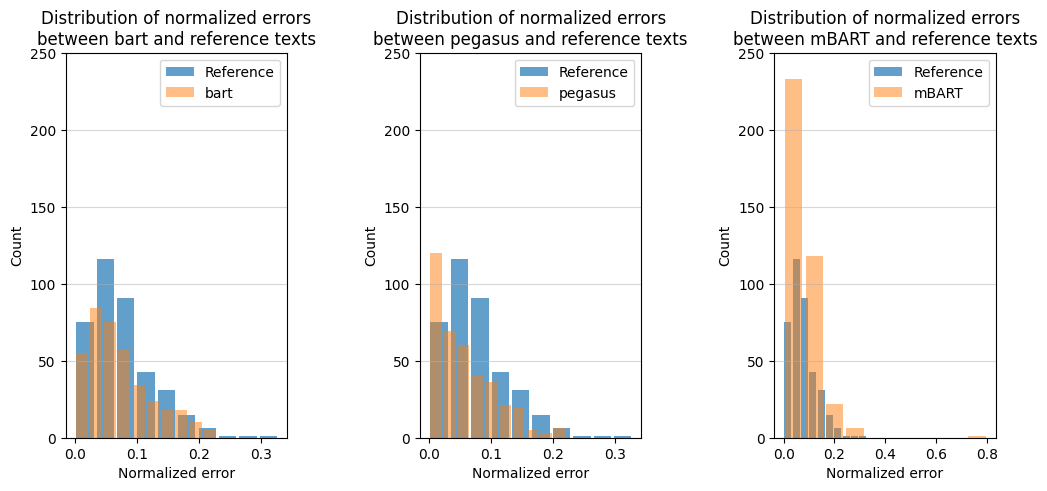

In [3]:
path = "../annotations_paraphrase/"
tool = language_tool_python.LanguageTool("en-US")
names_model = ["bart", "pegasus", "mBART"]
error = {name_model: [[], []] for name_model in names_model}

fig, axes = plt.subplots(1, len(names_model), figsize=(12, 5))
plt.subplots_adjust(wspace=0.6)

for i, (name_model, ax) in enumerate(zip(names_model, axes)):
    for path_json in glob.glob(path + "*.json"):
        content = tools.get_content(path_json, names_model + ["er"], name_model)
        if content != None :
            r_txt, p_txt, _, _ = content
            error[name_model][0].append(len(tool.check(r_txt)) / len(r_txt.split()))
            error[name_model][1].append(len(tool.check(p_txt)) / len(p_txt.split()))
    ax.hist(error[name_model][0], alpha=0.7, rwidth=0.85, label="Reference")
    ax.hist(error[name_model][1], alpha=0.5, rwidth=0.85, label=name_model)
    ax.grid(axis='y', alpha=0.5)
    ax.set_xlabel("Normalized error")
    ax.set_ylabel('Count')
    ax.set_ylim(0, 250)
    ax.set_title("Distribution of normalized errors\nbetween " + name_model + " and reference texts")
    ax.legend()

The following histograms illustrate the distribution of grammatical errors between the generated texts in yellow and the reference texts in blue.
The texts generated by the Bart model have fewer errors than the reference texts. In fact, the number of errors in the generated texts is smaller than in the reference texts, which illustrates that the model reduces grammatical errors.
The texts generated by the Pegasus model have fewer errors than the reference texts. The number of errors close to 0 is higher here. For the mBART model, the texts generated do not increase grammatical errors.

Thus, the Bart and Pegasus models are the most favourable according to this metric.

## Conclusion

According to the evaluation of the different metrics, the Bart model presents better results. In fact, it managed to retain contexts with the less grammatical errors and had the best entity conservation. The mBart model retained less contexts with a few grammatical errors but generated enough long texts and had good entity conservation. The Pegasus model generated texts that were not long enough, which may explain the loss of entity and context retention, but made few grammatical errors. 